In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout


Bad key text.latex.preview in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

In [2]:
btc = pd.read_csv('btc_historic.csv')
btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,13444.879883,15306.129883,12934.160156,14754.129883,14754.129883,1956783037
1,2018-01-03,14754.089844,15435.009766,14579.709961,15156.620117,15156.620117,1604206990
2,2018-01-04,15156.490234,15408.660156,14244.669922,15180.080078,15180.080078,1656714736
3,2018-01-05,15180.080078,17126.949219,14832.360352,16954.779297,16954.779297,2283988962
4,2018-01-06,16954.759766,17252.849609,16286.570313,17172.300781,17172.300781,1412703790
...,...,...,...,...,...,...,...
569,2019-07-25,9772.139648,10184.429688,9744.700195,9882.429688,9882.429688,403576364
570,2019-07-26,9882.429688,9890.049805,9668.519531,9847.450195,9847.450195,312717110
571,2019-07-27,9847.450195,10202.950195,9310.469727,9478.320313,9478.320313,512612117
572,2019-07-28,9478.320313,9591.519531,9135.639648,9531.769531,9531.769531,267243770


In [3]:
#get the number of trading days:
btc.shape

(574, 7)

In [4]:
#To make it as simple as possible we will just use one variable which is the “open” price.
#The reshape allows you to add dimensions or change the number of elements in each dimension.
#We are using reshape(-1, 1) because we have just one dimension in our array, so numby will create the same
#number of our rows and add one more axis: 1 to be the second dimension.
btc = btc['Open'].values
btc = btc.reshape(-1, 1)

In [5]:
#Now let’s split the data into training and testing sets:
dataset_train = np.array(btc[:int(btc.shape[0]*0.8)])
dataset_test = np.array(btc[:int(btc.shape[0]*0.8)])

In [6]:
#We will use the MinMaxScaler to scale our data between zero and one.
#In simpler words, the scaling is converting the numerical data represented in a wide range into a smaller one.
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [7]:
#Next, we will create the function that will help us to create the datasets:
#For the features (x), we will always append the last 50 prices, and for the label (y), we will append the next price. 
#Then we will use numpy to convert it into an array.
def create_dataset(btc):
    x = []
    y = []
    for i in range(50, btc.shape[0]):
        x.append(btc[i-50:i, 0])
        y.append(btc[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [8]:
#Now we are going to create our training and testing data by calling our function for each one:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [10]:
#Next, we need to reshape our data to make it a 3D array in order to use it in LSTM Layer.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
#Model building
#First, we initialized our model as a sequential one with 96 units in the output’s dimensionality.
#We used return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset.
#Making the dropout fraction 0.2 drops 20% of the layers.
#Finally, we added a dense layer with a value of 1 because we want to output one value.
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [13]:
#After that, we want to reshape our feature for the LSTM layer, 
#because it is sequential_3 which is expecting 3 dimensions, not 2:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
#Now we want to compile our model:
#We used loss='mean_squared_error' because it is a regression problem,
#and the adam optimizer to update network weights iteratively based on training data.
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
#Let’s save our model and start the training:
#Every epoch refers to one cycle through the full training dataset,
#and batch size refers to the number of training examples utilized in one iteration.
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('btc_predictions.h5')

Epoch 1/50
13/13 [==============================] - 1s 47ms/step - loss: 0.0013
Epoch 2/50
13/13 [==============================] - 1s 48ms/step - loss: 0.0011
Epoch 3/50
13/13 [==============================] - 1s 47ms/step - loss: 0.0013
Epoch 4/50
13/13 [==============================] - 1s 48ms/step - loss: 0.0012
Epoch 5/50
13/13 [==============================] - 1s 47ms/step - loss: 0.0011
Epoch 6/50
13/13 [==============================] - 1s 47ms/step - loss: 0.0013
Epoch 7/50
13/13 [==============================] - 1s 47ms/step - loss: 9.7288e-04
Epoch 8/50
13/13 [==============================] - 1s 51ms/step - loss: 0.0010
Epoch 9/50
13/13 [==============================] - 1s 49ms/step - loss: 0.0012
Epoch 10/50
13/13 [==============================] - 1s 50ms/step - loss: 0.0013
Epoch 11/50
13/13 [==============================] - 1s 50ms/step - loss: 0.0011
Epoch 12/50
13/13 [==============================] - 1s 49ms/step - loss: 0.0012
Epoch 13/50
13/13 [==============

In [19]:
#Let’s load our model:
model = load_model('btc_predictions.h5')

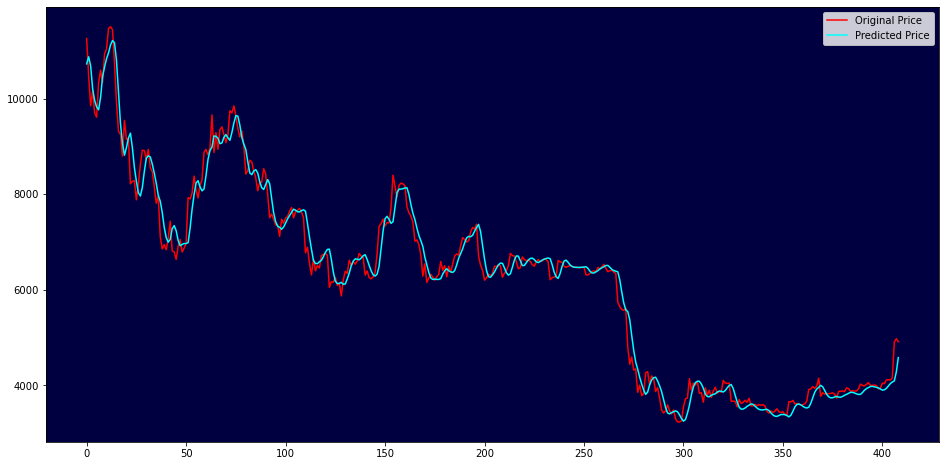

In [22]:
#Results visualization
#The last step is to visualize our data.
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color = 'red', label = 'Original Price')
plt.plot(predictions, color = 'cyan', label = 'Predicted Price')
plt.legend()

In [ ]:
#We got a very good prediction result! Imagine if you are working with
#multiple variables, how much more accurate the result could be?

#I also recommend you to change layers, numbers, epochs, and batch_size.
#Try it out for yourself and change whatever you think may improve your prediction and more accurate.